<a href="https://colab.research.google.com/github/aksh-ay06/Quality-and-Reliability-Engineering-Final-Project/blob/main/Quality_and_Reliabilty_Engineering_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance
from sklearn.cluster import KMeans
from scipy import stats

plt.style.use("seaborn-v0_8-whitegrid")

# 1. Load dataset
path = "/content/Project_dataset.xlsx"
df = pd.read_excel(path, sheet_name="Project_dataset", header=None)  # 552 x 209
n_obs, n_var = df.shape
print("Shape:", df.shape)


Shape: (552, 209)


     count       mean       std   min   25%   50%   75%   max
0    552.0   0.425725  1.290025  -6.0   0.0   0.0   1.0   4.0
1    552.0  -9.954710  2.061605 -17.0 -11.0  -9.0  -9.0  -3.0
2    552.0 -13.534420  2.480174 -20.0 -16.0 -14.0 -12.0  -4.0
3    552.0 -14.402174  2.637410 -25.0 -16.0 -14.0 -12.0  -6.0
4    552.0 -14.623188  2.648022 -22.0 -17.0 -14.0 -12.0  -8.0
..     ...        ...       ...   ...   ...   ...   ...   ...
204  552.0 -25.025362  4.015769 -36.0 -28.0 -25.0 -22.0 -14.0
205  552.0 -28.271739  4.065087 -40.0 -32.0 -28.0 -25.0 -17.0
206  552.0 -29.708333  4.464834 -43.0 -33.0 -30.0 -27.0 -11.0
207  552.0 -28.163043  5.501250 -41.0 -32.0 -28.0 -25.0  -8.0
208  552.0 -25.077899  5.838052 -44.0 -28.0 -25.0 -22.0  -4.0

[209 rows x 8 columns]
Missing values per column:
0      0
1      0
2      0
3      0
4      0
      ..
204    0
205    0
206    0
207    0
208    0
Length: 209, dtype: int64


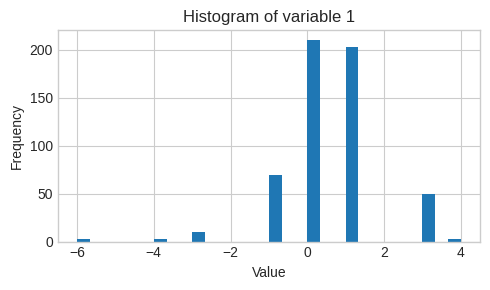

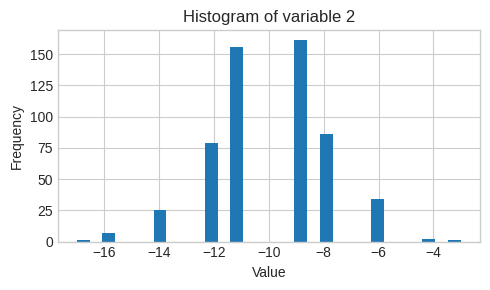

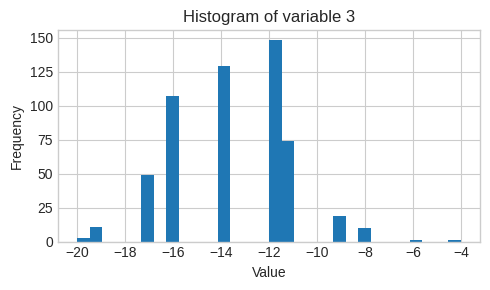

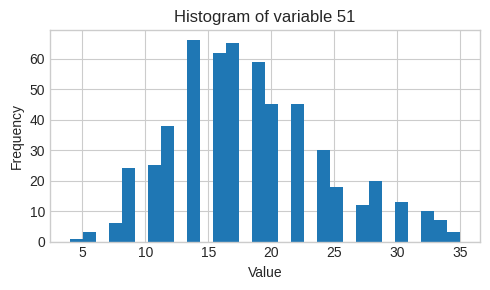

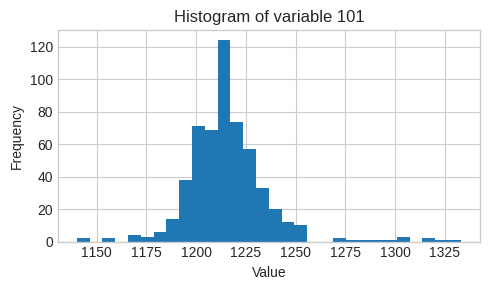

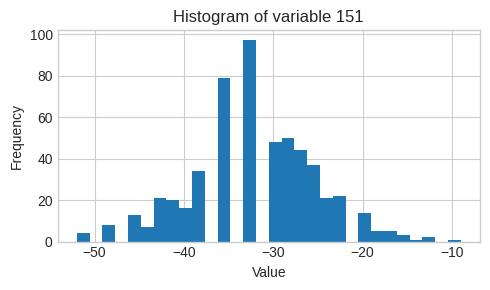

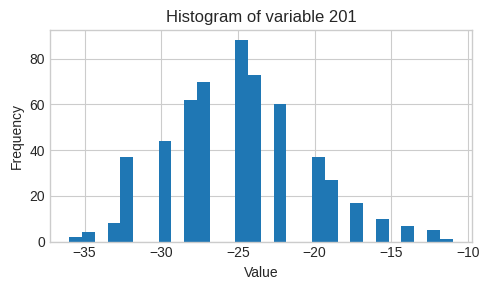

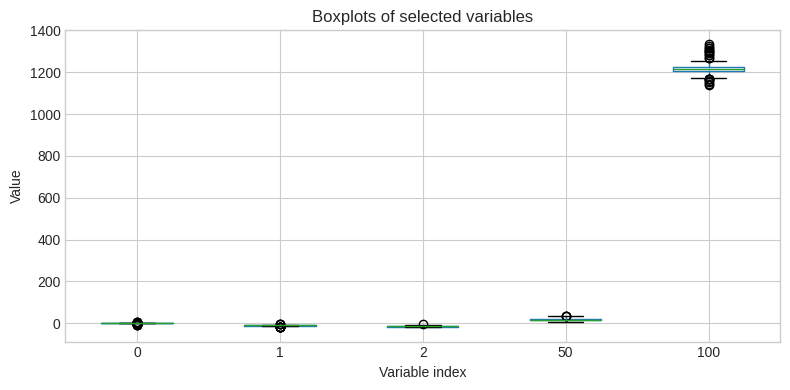

In [ ]:
# 2. Basic descriptive statistics
print(df.describe().T)      # per-variable summary

# 3. Missing values
print("Missing values per column:")
print(df.isna().sum())

# 4. Simple univariate histograms for a few variables
for j in [0, 1, 2, 50, 100, 150, 200]:
    if j < n_var:
        plt.figure(figsize=(5,3))
        df.iloc[:, j].hist(bins=30)
        plt.title(f"Histogram of variable {j+1}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# 5. Boxplots for selected variables
plt.figure(figsize=(8,4))
df.iloc[:, [0, 1, 2, 50, 100]].boxplot()
plt.title("Boxplots of selected variables")
plt.xlabel("Variable index")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


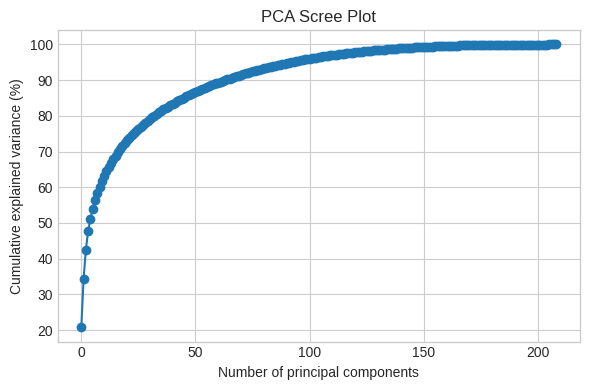

Selected number of PCs: 46


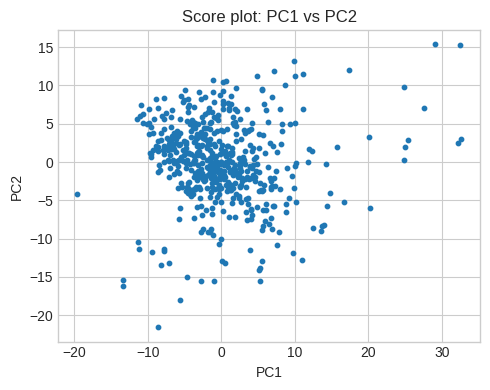

In [ ]:
# 6. Standardize all variables
scaler = StandardScaler()
X_std = scaler.fit_transform(df.values)

# 7. PCA to reduce dimension
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Scree plot
cum_var = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(6,4))
plt.plot(cum_var, marker="o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("PCA Scree Plot")
plt.tight_layout()
plt.show()

# Choose k PCs to retain (e.g., enough to explain ~80–90% variance)
k = np.argmax(cum_var >= 85) + 1  # automatic choice; adjust if you prefer
print("Selected number of PCs:", k)
X_pca_k = X_pca[:, :k]

# Scatter of first two PCs
plt.figure(figsize=(5,4))
plt.scatter(X_pca_k[:,0], X_pca_k[:,1], s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Score plot: PC1 vs PC2")
plt.tight_layout()
plt.show()


In [ ]:
# 8. Robust covariance model in PC space
# contamination is an initial guess for OOC proportion; tune if needed
contamination = 0.1

ee = EllipticEnvelope(contamination=contamination, random_state=0)
ee.fit(X_pca_k)

# 1 = in-control, -1 = out-of-control
y_pred_ee = ee.predict(X_pca_k)
scores_ee = ee.decision_function(X_pca_k)

df_phase1 = df.copy()
df_phase1["EE_IC"] = (y_pred_ee == 1).astype(int)
df_phase1["EE_score"] = scores_ee

print("EllipticEnvelope IC/OOC counts:")
print(df_phase1["EE_IC"].value_counts())


EllipticEnvelope IC/OOC counts:
EE_IC
1    496
0     56
Name: count, dtype: int64


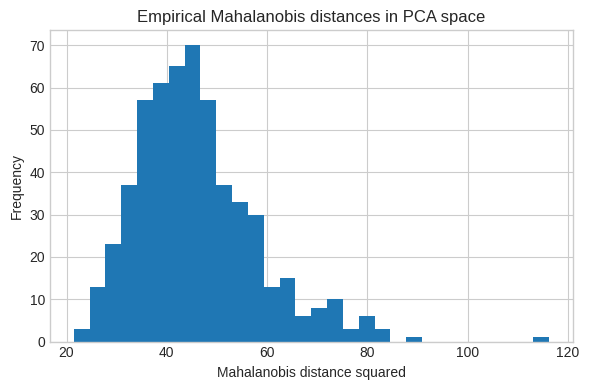

Chi-square threshold: 71.20140024831149
MD-based IC/OOC counts:
MD_IC
1    527
0     25
Name: count, dtype: int64


In [ ]:
# 9. Empirical covariance Mahalanobis distances in PCA space
cov_emp = EmpiricalCovariance().fit(X_pca_k)
md2 = cov_emp.mahalanobis(X_pca_k)

df_phase1["MD2"] = md2

plt.figure(figsize=(6,4))
plt.hist(md2, bins=30)
plt.xlabel("Mahalanobis distance squared")
plt.ylabel("Frequency")
plt.title("Empirical Mahalanobis distances in PCA space")
plt.tight_layout()
plt.show()

# Chi-square threshold for given alpha
alpha = 0.01
chi2_thr = stats.chi2.ppf(1 - alpha, df=k)
print("Chi-square threshold:", chi2_thr)

df_phase1["MD_IC"] = (df_phase1["MD2"] <= chi2_thr).astype(int)
print("MD-based IC/OOC counts:")
print(df_phase1["MD_IC"].value_counts())


In [ ]:
# 10. Combined Phase I decision: robust + empirical
df_phase1["IC_combined"] = ((df_phase1["EE_IC"] == 1) &
                            (df_phase1["MD_IC"] == 1)).astype(int)
print("Combined IC/OOC counts:")
print(df_phase1["IC_combined"].value_counts())

# Extract in-control and OOC subsets in original-space variables
df_IC = df_phase1[df_phase1["IC_combined"] == 1].iloc[:, :n_var]
df_OOC = df_phase1[df_phase1["IC_combined"] == 0].iloc[:, :n_var]
print("In-control size:", df_IC.shape[0], "Out-of-control size:", df_OOC.shape[0])

# Index lists for later plots / referencing
IC_indices = df_phase1.index[df_phase1["IC_combined"] == 1].to_numpy()
OOC_indices = df_phase1.index[df_phase1["IC_combined"] == 0].to_numpy()


Combined IC/OOC counts:
IC_combined
1    484
0     68
Name: count, dtype: int64
In-control size: 484 Out-of-control size: 68


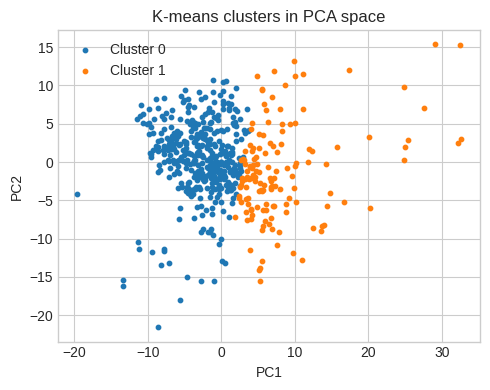

Cluster vs EllipticEnvelope IC label:
EE_IC (1=IC)   0    1
cluster              
0             36  373
1             20  123


In [ ]:
# 11. K-means clustering on PCA scores (for insight into structure)
K = 2  # because there is a natural IC/OOC dichotomy; can try K=3,4 as well
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto")
clusters = kmeans.fit_predict(X_pca_k)
df_phase1["cluster"] = clusters

# Visualize clusters in PC1-PC2 space
plt.figure(figsize=(5,4))
for c in range(K):
    idx = (clusters == c)
    plt.scatter(X_pca_k[idx,0], X_pca_k[idx,1], s=10, label=f"Cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space")
plt.legend()
plt.tight_layout()
plt.show()

# Compare clusters with EE-based labels
ct = pd.crosstab(df_phase1["cluster"], df_phase1["EE_IC"],
                 rownames=["cluster"], colnames=["EE_IC (1=IC)"])
print("Cluster vs EllipticEnvelope IC label:")
print(ct)


In [ ]:
# 12. Estimate in-control mean and covariance in original space
mu_IC = df_IC.mean(axis=0).values
Sigma_IC = np.cov(df_IC.values, rowvar=False)

print("In-control mean vector shape:", mu_IC.shape)
print("In-control covariance matrix shape:", Sigma_IC.shape)

# Save for future use if needed
pd.Series(mu_IC).to_csv("IC_mean_vector.csv", index=False)
pd.DataFrame(Sigma_IC).to_csv("IC_cov_matrix.csv", index=False)


In-control mean vector shape: (209,)
In-control covariance matrix shape: (209, 209)


Hotelling T² UCL: 495.4860779114199


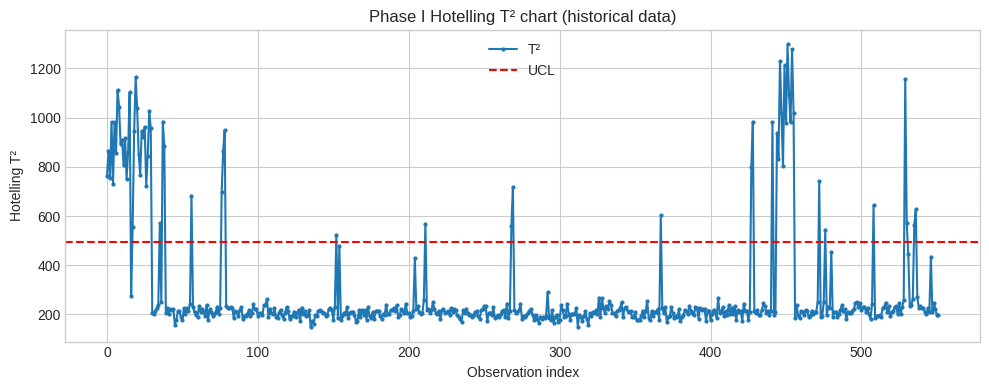

In [ ]:
# 13. Hotelling T² function
def hotellings_T2(x_row, mu, Sigma_inv):
    diff = x_row - mu
    return float(diff.T @ Sigma_inv @ diff)

Sigma_IC_inv = np.linalg.inv(Sigma_IC)

# Phase I T² for all historical observations using IC parameters
T2_hist = []
for i in range(n_obs):
    x = df.iloc[i, :].values
    T2_hist.append(hotellings_T2(x, mu_IC, Sigma_IC_inv))

df_phase1["T2"] = T2_hist

# F-approximation UCL for Phase I (using IC sample size)
m = df_IC.shape[0]
p = n_var

alpha_T2 = 0.01
UCL_T2 = (p * (m - 1) / (m - p)) * stats.f.ppf(1 - alpha_T2, p, m - p)
print("Hotelling T² UCL:", UCL_T2)

# T² control chart for historical data
plt.figure(figsize=(10,4))
plt.plot(df_phase1.index, df_phase1["T2"], marker="o", ms=2, linestyle="-", label="T²")
plt.axhline(UCL_T2, color="red", linestyle="--", label="UCL")
plt.xlabel("Observation index")
plt.ylabel("Hotelling T²")
plt.title("Phase I Hotelling T² chart (historical data)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Function to monitor future observations in Phase II
def phaseII_monitor(new_data, mu_IC, Sigma_IC_inv, UCL_T2):
    """
    new_data: pandas DataFrame or 2D numpy array of new observations (rows).
    Returns a DataFrame with T² values and IC/OOC decisions.
    """
    if isinstance(new_data, pd.DataFrame):
        X_new = new_data.values
    else:
        X_new = np.asarray(new_data)

    T2_vals = []
    for i in range(X_new.shape[0]):
        T2_vals.append(hotellings_T2(X_new[i, :], mu_IC, Sigma_IC_inv))

    result = pd.DataFrame({
        "T2": T2_vals,
        "IC_flag": (np.array(T2_vals) <= UCL_T2).astype(int)
    })
    return result


new_data_example = df.tail(50)
phaseII_results = phaseII_monitor(new_data_example, mu_IC, Sigma_IC_inv, UCL_T2)
print(phaseII_results.head())


           T2  IC_flag
0  231.437530        1
1  210.263063        1
2  227.707076        1
3  199.863510        1
4  181.650390        1
